In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import pearsonr, ttest_ind
from sklearn.linear_model import LinearRegression

In [2]:
# PRS threshold
prs_th = 0.5

# Get dataframe
df = pd.read_csv(f'data/processed_data/processed_data_{prs_th}.csv')

# Column names of interes
info = ['AGEYR', 'SEX']
prs_types = ['GM', 'WM', 'FC']
prs_cols = ['{}_ZSCORE'.format(prs_type) for prs_type in prs_types]
genetics = ['APOEGN']
amyloid = ['Amyloid']
plasma_factors = ['pTau217', 'BP40', 'BP42', 'FP40', 'FP40/TP40', 'FP42', 'FP42/FP40',
                  'FP42/TP42', 'TP40', 'TP42', 'TP42/TP40', 'AMYLB40', 'AMYLB42', 
                  'APOE4', 'GFAP ', 'NF-L ', 'TPP181']

## Distribution of PRS

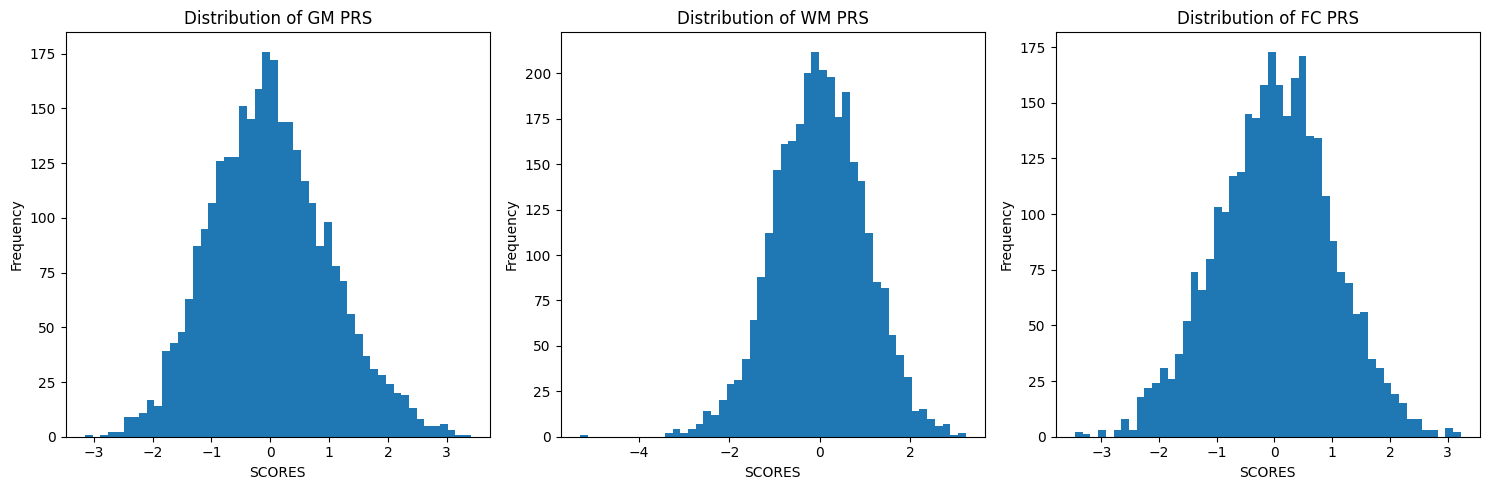

In [3]:
# Show distributions of ZSCORES for each prs type
plt.figure(figsize=(15, 5))
for prs_type in prs_types:
    plt.subplot(1, 3, prs_types.index(prs_type) + 1)
    plt.hist(df['{}_ZSCORE'.format(prs_type)], bins=50)
    plt.title('Distribution of {} PRS'.format(prs_type))
    plt.xlabel('SCORES')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Correlation with Plasma measurments

Correlation beetween PRS measures and plasma measurments on residuals corrected by age

In [4]:
# Calculate Pearson correlation between PRS and different values

# Dataframe to store results
df_factors = pd.DataFrame(columns=['Factor']+ [prs + '_corr' for prs in prs_types]
                          + [prs + '_pval' for prs in prs_types])

# Calculate correlation between PRS and plasma factors
for factor in plasma_factors:
    # Create new empty row for factor
    row = {'Factor': factor}
    df_factor = df[['AGEYR'] + [factor] + prs_cols].copy().dropna()
    
    # Fit linear model for residuals
    X = df_factor['AGEYR'].values.reshape(-1, 1)
    factor_values = df_factor[factor].values

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, factor_values)
        
    # Calculate predicted values
    y_pred = model.predict(X)
        
    # Calculate residuals
    df_factor[f'{factor}_residual'] = df_factor[factor] - y_pred

    # Calculate correlation between PRS and residuals
    for prs in prs_types:
        corr, p_val = pearsonr(df_factor['{}_ZSCORE'.format(prs)], df_factor[f'{factor}_residual'])
        row[prs+'_corr'], row[prs+'_pval'] = corr, p_val
    df_factors = pd.concat([df_factors, pd.DataFrame([row])], ignore_index=True)

# Show results
print(df_factors)

# Obtain which factors have p_val < 0.05
for prs in prs_types:
    print('Factors with p_val < 0.05 for {} PRS:'.format(prs))
    significant_factors = df_factors[df_factors[prs+'_pval'] < 0.05]['Factor'].to_list()
    for factor in significant_factors:
        print("Factor: {}, Correlation: {}, p_val: {}".format(factor, 
                                                              df_factors[df_factors['Factor'] == factor][prs+'_corr'].values[0], 
                                                              df_factors[df_factors['Factor'] == factor][prs+'_pval'].values[0]))

       Factor   GM_corr   WM_corr   FC_corr   GM_pval   WM_pval   FC_pval
0     pTau217  0.052885  0.039117 -0.011844  0.151771  0.289229  0.748383
1        BP40  0.025763 -0.009250 -0.023088  0.191494  0.639128  0.241796
2        BP42  0.015192 -0.005554 -0.033820  0.458819  0.786525  0.099040
3        FP40  0.042984  0.005531  0.009509  0.028400  0.778020  0.627938
4   FP40/TP40  0.022135  0.029287 -0.020209  0.260771  0.136734  0.304554
5        FP42  0.016302 -0.002479 -0.015628  0.421441  0.902710  0.440901
6   FP42/FP40  0.006591 -0.006680 -0.010915  0.745434  0.742122  0.590802
7   FP42/TP42 -0.000009  0.024361  0.001727  0.999642  0.233061  0.932630
8        TP40  0.030166 -0.009415 -0.016423  0.124688  0.631855  0.403283
9        TP42  0.015142 -0.007735 -0.025656  0.449912  0.699557  0.200426
10  TP42/TP40 -0.007996  0.005707 -0.016073  0.690504  0.776280  0.423483
11    AMYLB40  0.040948  0.060373 -0.033473  0.098404  0.014776  0.176768
12    AMYLB42  0.046501  0.045958 -0.0

/var/folders/wd/4_xdznzj3lschk4f9mkq4t7h0000gn/T/ipykernel_43832/617777153.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_factors = pd.concat([df_factors, pd.DataFrame([row])], ignore_index=True)


## GLM

y = b0*intercept + b1*age + b2*prs + b3*prs*age

In [5]:
# Create a GLM model for each factor
for factor in plasma_factors:
    df_factor = df[['AGEYR'] + [factor] + prs_cols].copy().dropna()
    # Normalize age
    df_factor['AGEYR'] = (df_factor['AGEYR'] - df_factor['AGEYR'].mean()) / df_factor['AGEYR'].std()
    # For each PRS type
    for prs in prs_cols:
        # Interaction of Age and PRS
        df_factor['AGEYR_{}'.format(prs)] = df_factor['AGEYR'] * df_factor[prs]
        # Fit GLM model
        X = sm.add_constant(df_factor[['AGEYR', prs, 'AGEYR_{}'.format(prs)]])
        model = sm.GLM(df_factor[factor], X, family=sm.families.Gaussian()).fit()

        # Show significant resulds smaller than 0.05
        pvals = model.pvalues
        params = model.params
        if pvals[prs] < 0.05:
            print('Condition {}, Factor: {}, PRS: {}, p_val: {}, param: {}'.format(prs, factor, prs, pvals[prs], params[prs]))
        if pvals['AGEYR_{}'.format(prs)] < 0.05:
            print('Condition {}, Factor: {}, PRS: {}, p_val: {}, param:{}'.format(f'AGE_{prs}', factor, prs, pvals['AGEYR_{}'.format(prs)], params['AGEYR_{}'.format(prs)]))



Condition AGE_GM_ZSCORE, Factor: pTau217, PRS: GM_ZSCORE, p_val: 0.007298769708719453, param:0.014473465509791268
Condition GM_ZSCORE, Factor: FP40, PRS: GM_ZSCORE, p_val: 0.028359916933334922, param: 1.3340486159154388
Condition AGE_WM_ZSCORE, Factor: FP42/FP40, PRS: WM_ZSCORE, p_val: 0.019899015764303078, param:0.0032843541825344214
Condition WM_ZSCORE, Factor: AMYLB40, PRS: WM_ZSCORE, p_val: 0.014671008194794903, param: 0.002938112422526589
Condition GM_ZSCORE, Factor: TPP181, PRS: GM_ZSCORE, p_val: 0.04240622747368462, param: 0.030308220942089223
Condition AGE_GM_ZSCORE, Factor: TPP181, PRS: GM_ZSCORE, p_val: 0.04034846152419309, param:0.03007146514443706
Condition AGE_WM_ZSCORE, Factor: TPP181, PRS: WM_ZSCORE, p_val: 0.04296754623665011, param:0.029618159923177734


## Seperate by status

Mean GM PRS for positive amyloid status: 0.016197817192284903
Mean GM PRS for negative amyloid status: -0.007318666920210201
T-test for GM PRS: t_stat: 0.5976811125980682, p_val: 0.5500976619148643
Mean WM PRS for positive amyloid status: -0.02600400373396656
Mean WM PRS for negative amyloid status: 0.011749400531051541
T-test for WM PRS: t_stat: -0.9596080526173266, p_val: 0.33732953718143077
Mean FC PRS for positive amyloid status: 0.01299490817710526
Mean FC PRS for negative amyloid status: -0.005871495120481874
T-test for FC PRS: t_stat: 0.47948726391259494, p_val: 0.631626838603774


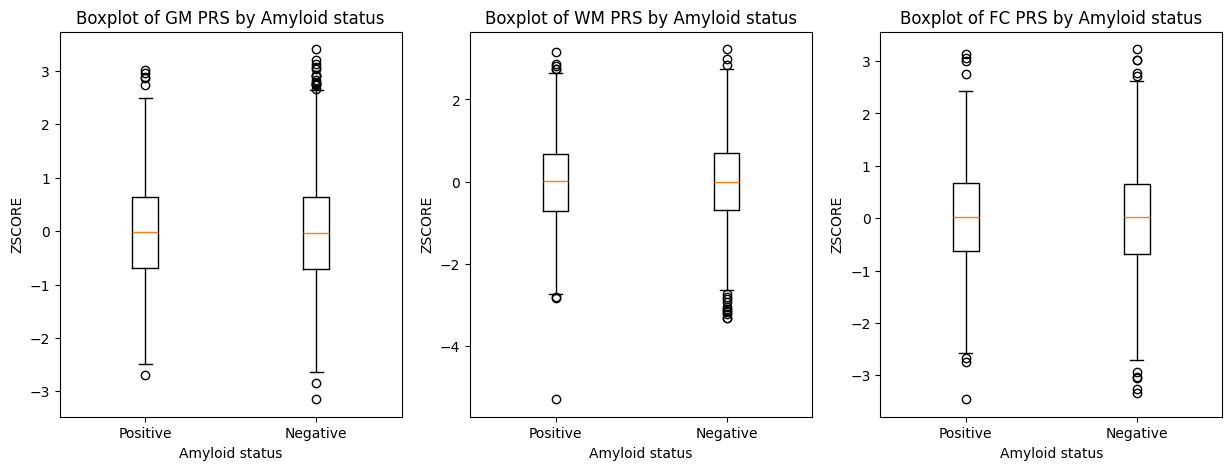

In [6]:
# Obtaain subject by amyloid status
df_pos = df[df['Amyloid'] == 'positive']
df_neg = df[df['Amyloid'] == 'negative']

# Plot boxplots for each PRS type for each status in one figure
plt.figure(figsize=(15, 5))

for prs in prs_types:
    # Obtain prs
    pos_prs = df_pos['{}_ZSCORE'.format(prs)].dropna().to_numpy()
    neg_prs = df_neg['{}_ZSCORE'.format(prs)].dropna().to_numpy()
    print('Mean {} PRS for positive amyloid status: {}'.format(prs, pos_prs.mean()))
    print('Mean {} PRS for negative amyloid status: {}'.format(prs, neg_prs.mean()))

    # Caclulate t-test
    t_stat, p_val = ttest_ind(pos_prs, neg_prs)
    print('T-test for {} PRS: t_stat: {}, p_val: {}'.format(prs, t_stat, p_val))

    # Plot boxplot
    plt.subplot(1, 3, prs_types.index(prs) + 1)
    plt.boxplot([pos_prs, neg_prs])
    plt.title('Boxplot of {} PRS by Amyloid status'.format(prs))
    plt.xlabel('Amyloid status')
    plt.ylabel('ZSCORE')
    plt.xticks([1, 2], ['Positive', 'Negative'])
plt.show()

Number of subjects with E4 allele: 1888
Number of subjects without E4 allele: 3601
Mean GM PRS for No E4 E4 status: 0.005908765583561601
Mean GM PRS for E4 E4 status: -0.011862515923667405
T-test for GM PRS: t_stat: -0.4658752677934692, p_val: 0.6413387529682657
Mean WM PRS for No E4 E4 status: 0.009451744567970464
Mean WM PRS for E4 E4 status: -0.015906010262414123
T-test for WM PRS: t_stat: -0.6642739779481317, p_val: 0.5065662458673791
Mean FC PRS for No E4 E4 status: -0.0004898416626906517
Mean FC PRS for E4 E4 status: -0.0006410039055524415
T-test for FC PRS: t_stat: -0.003967228590462843, p_val: 0.9968348827833322


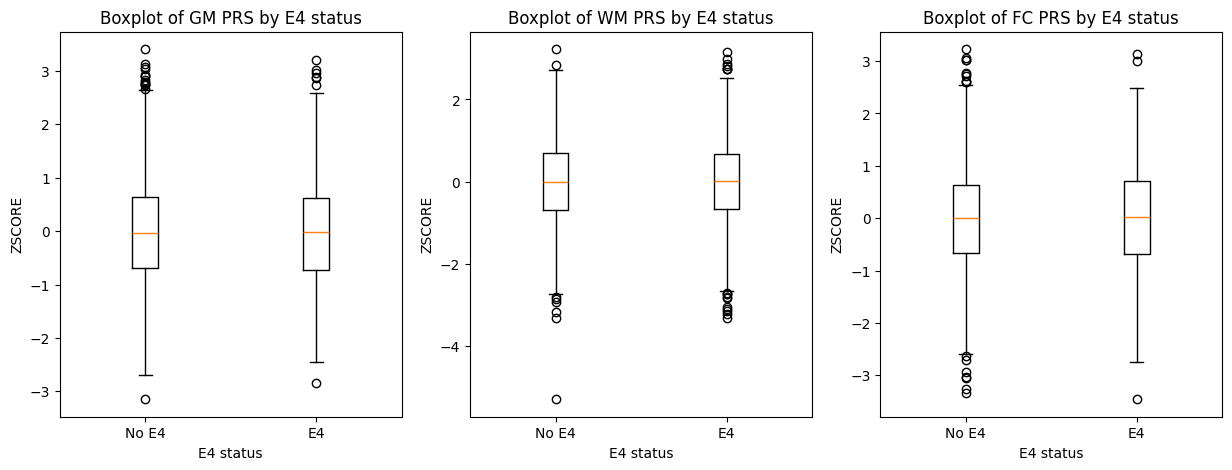

In [7]:
# Contains E4 allele vs does not contain E4 allele
df_e4 = df.copy()
df_e4['E4'] = df['APOEGN'].dropna().apply(lambda x: 'E4' if 'E4' in x else 'No E4')
e4_types = df_e4['E4'].dropna().unique()
print('Number of subjects with E4 allele: {}'.format(df_e4[df_e4['E4'] == 'E4'].shape[0]))
print('Number of subjects without E4 allele: {}'.format(df_e4[df_e4['E4'] == 'No E4'].shape[0]))

# Plot boxplots for each PRS type for each status in one figure
plt.figure(figsize=(15, 5))
for prs in prs_types:
    # Get PRS for each genotype
    e4_dict = {}
    for e4 in e4_types:
        e4_prs = df_e4[df_e4['E4'] == e4]['{}_ZSCORE'.format(prs)].dropna().to_numpy()
        e4_dict[e4] = e4_prs
        print('Mean {} PRS for {} E4 status: {}'.format(prs, e4, e4_prs.mean()))
    
    # T-test
    t_stat, p_val = ttest_ind(e4_dict['E4'], e4_dict['No E4'])
    print('T-test for {} PRS: t_stat: {}, p_val: {}'.format(prs, t_stat, p_val))

    # Plot boxplots
    plt.subplot(1, 3, prs_types.index(prs) + 1)
    plt.boxplot([e4_dict[e4] for e4 in e4_types])
    plt.title('Boxplot of {} PRS by E4 status'.format(prs))
    plt.xlabel('E4 status')
    plt.ylabel('ZSCORE')
    plt.xticks(range(1, len(e4_types)+1), e4_types)
plt.show()